# CIFAR-10 Data Exploration

This notebook explores the CIFAR-10 dataset and visualizes data augmentations.

In [1]:
import sys
sys.path.append('../src')

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
from data import get_dataloaders, get_class_names, denormalize
from utils import load_config

In [4]:
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load Configuration and Data

In [5]:
# load Config
config = load_config('../config.yaml')
print("Configuration loaded successfully!")

Configuration loaded successfully!


In [6]:
# Load Data
train_loader, val_loader, test_loader = get_dataloaders(config)
class_names = get_class_names()

Loading CIFAR-10 dataset...
Training samples: 45000
Validation samples: 5000
Test samples: 10000


In [7]:
print(f"\nClass names: {class_names}")


Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 2. Dataset Statistics

In [8]:
#Count Samples
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 176
Validation batches: 20
Test batches: 40


In [9]:
# Get a batch
images, labels = next(iter(train_loader))
print(f"\nBatch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Image range: [{images.min():.2f}, {images.max():.2f}]")

E:\PROJECT\vit_classifier\cifar\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Batch shape: torch.Size([256, 3, 72, 72])
Labels shape: torch.Size([256])
Image range: [-2.12, 2.64]


## 3. Class Distribution

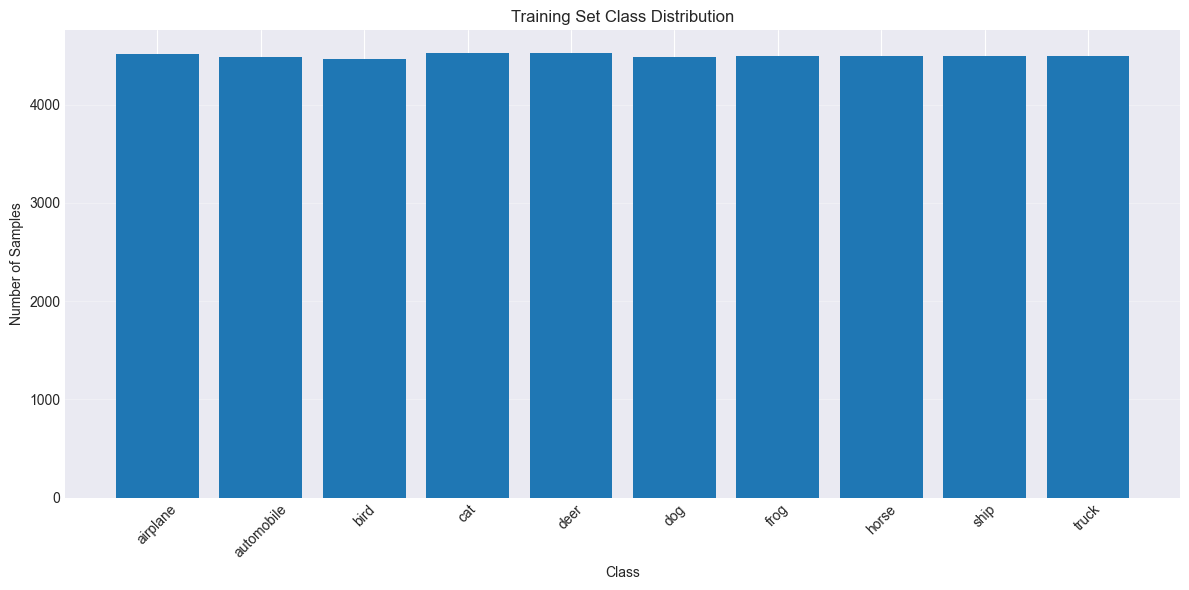


Class distribution: 
airplane    :  4512 samples
automobile  :  4488 samples
bird        :  4468 samples
cat         :  4529 samples
deer        :  4529 samples
dog         :  4486 samples
frog        :  4493 samples
horse       :  4500 samples
ship        :  4496 samples
truck       :  4499 samples


In [11]:
# Collect all labels
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.numpy())
label_counts = Counter(all_labels)

# Plot distribution
plt.figure(figsize=(12, 6))
plt.bar(range(10), [label_counts[i] for i in range(10)])
plt.xticks(range(10), class_names, rotation=45)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Training Set Class Distribution')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nClass distribution: ")
for i, name in enumerate(class_names):
    print(f"{name:12s}: {label_counts[i]:5d} samples")

## 4. Sample Images

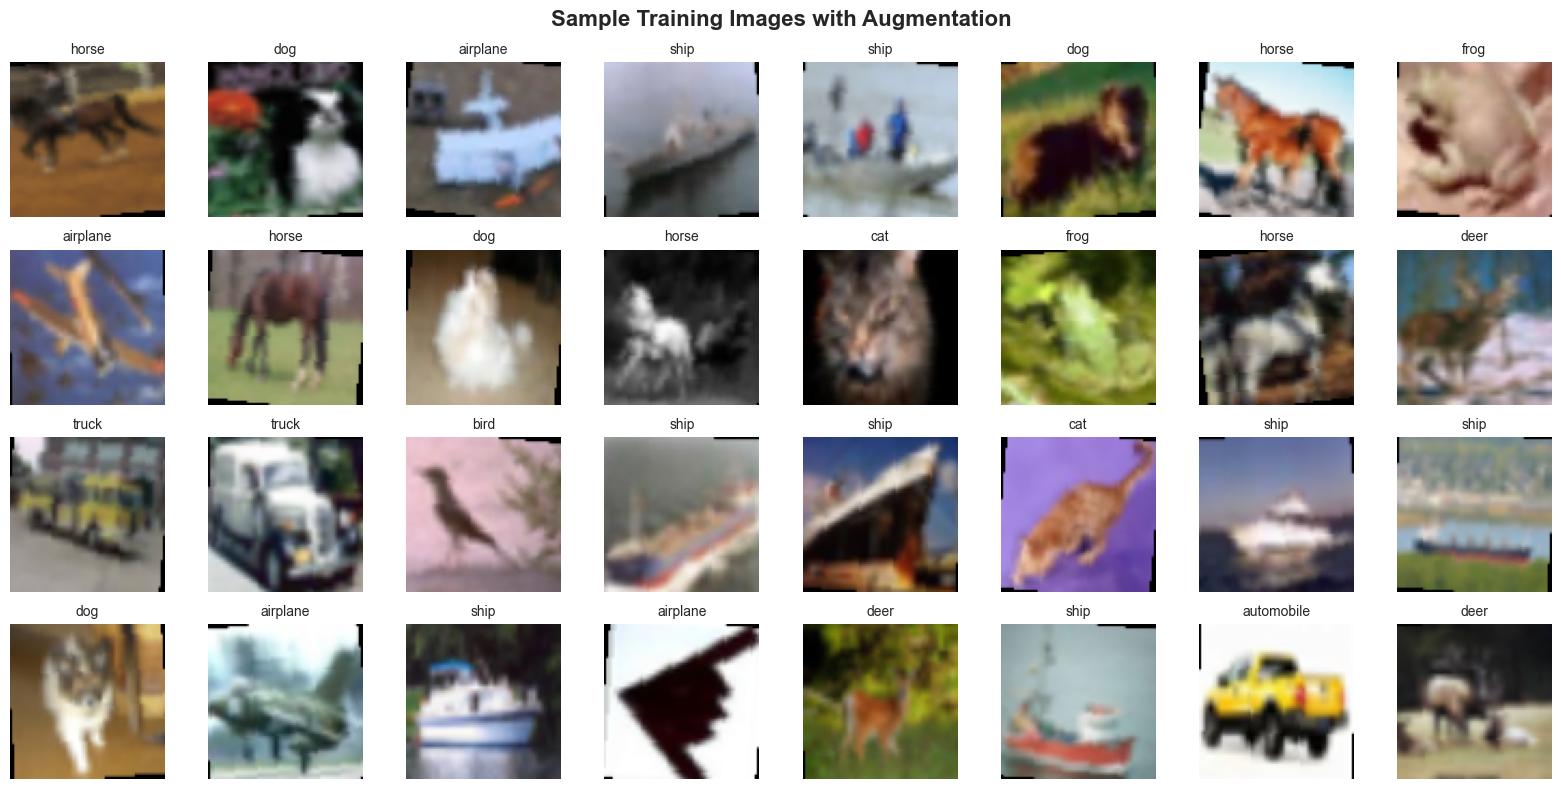

In [13]:
# Visualize random samples
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

images, labels = next(iter(train_loader))

for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        # Denormalize
        img = denormalize(
            images[idx],
            config['augmentation']['normalize_mean'],
            config['augmentation']['normalize_std'],
        )
        img = torch.clamp(img, 0, 1)

        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(class_names[labels[idx]], fontsize=10)
        ax.axis('off')
plt.suptitle('Sample Training Images with Augmentation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Per-Class Examples

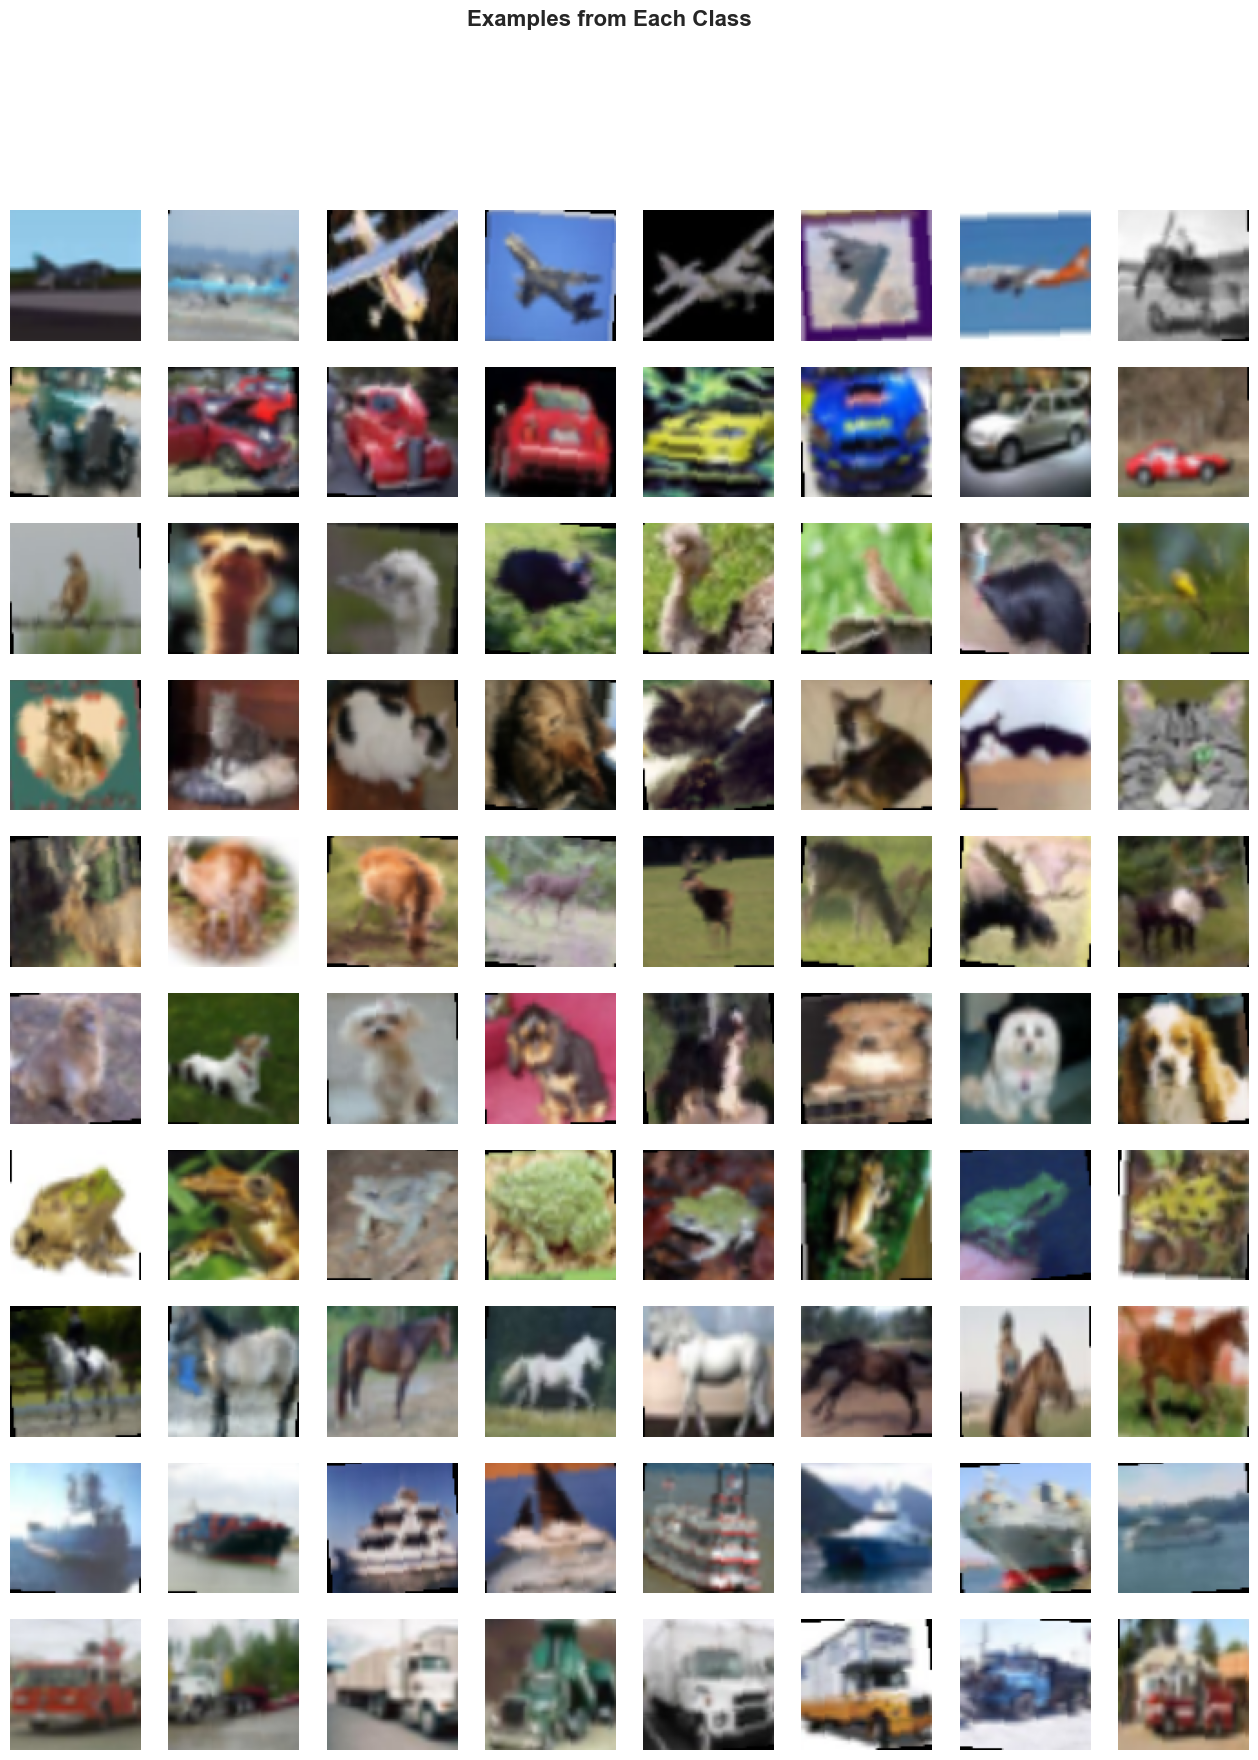

In [18]:
# Show examples for each class
fig, axes = plt.subplots(10, 8, figsize=(16, 20))

# Collect images per class
class_images = {i: [] for i in range(10)}

for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if len(class_images[label]) < 8:
            class_images[label].append(img)
    
    # Break if we have enough
    if all(len(v) >= 8 for v in class_images.values()):
        break

# Plot
for class_idx in range(10):
    for img_idx in range(8):
        ax = axes[class_idx, img_idx]
        
        img = denormalize(
            class_images[class_idx][img_idx],
            config['augmentation']['normalize_mean'],
            config['augmentation']['normalize_std']
        )
        img = torch.clamp(img, 0, 1)
        
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
        
        if img_idx == 0:
            ax.set_ylabel(class_names[class_idx], fontsize=12, fontweight='bold')

plt.suptitle('Examples from Each Class', fontsize=16, fontweight='bold')
plt.show()

## 6. Patch Visualization

Image shape: torch.Size([1, 3, 72, 72])
Patches shape: torch.Size([1, 144, 108])
Number of patches: 144
Patch dimension: 108


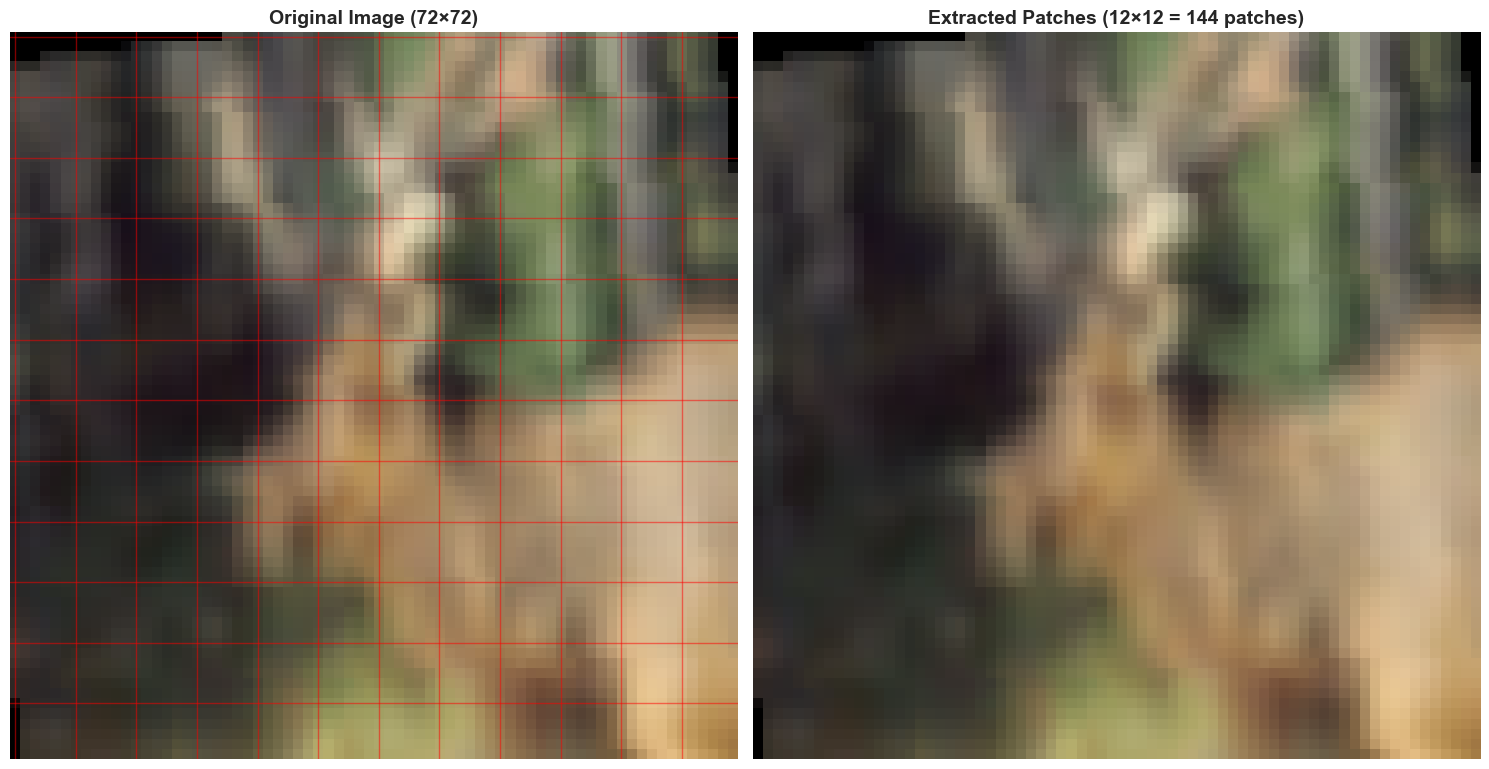

In [21]:
# Visualize how images are split into patches
from model import PatchExtractor

patch_size = config['model']['patch_size']
patch_extractor = PatchExtractor(patch_size)

# Get one image
img_tensor = images[0:1]
patches = patch_extractor(img_tensor)

print(f"Image shape: {img_tensor.shape}")
print(f"Patches shape: {patches.shape}")
print(f"Number of patches: {patches.shape[1]}")
print(f"Patch dimension: {patches.shape[2]}")

# Visualize original and patches
fig = plt.figure(figsize=(15, 12))

# Original image
ax = plt.subplot(1, 2, 1)
img_display = denormalize(
    img_tensor[0],
    config['augmentation']['normalize_mean'],
    config['augmentation']['normalize_std']
)
img_display = torch.clamp(img_display, 0, 1)
ax.imshow(img_display.permute(1, 2, 0))
ax.set_title('Original Image (72×72)', fontsize=14, fontweight='bold')
ax.axis('off')

# Draw grid
image_size = config['data']['image_size']
for i in range(0, image_size, patch_size):
    ax.axhline(i, color='red', linewidth=1, alpha=0.5)
    ax.axvline(i, color='red', linewidth=1, alpha=0.5)

# Patches grid
ax = plt.subplot(1, 2, 2)
num_patches_per_side = image_size // patch_size

# Reconstruct patches into grid
patches_reshaped = patches[0].reshape(num_patches_per_side, num_patches_per_side, 3, patch_size, patch_size)
patches_reshaped = patches_reshaped.permute(0, 3, 1, 4, 2).contiguous()
patches_grid = patches_reshaped.reshape(image_size, image_size, 3)

# Denormalize
mean = torch.tensor(config['augmentation']['normalize_mean']).view(1, 1, 3)
std = torch.tensor(config['augmentation']['normalize_std']).view(1, 1, 3)
patches_grid = patches_grid * std + mean
patches_grid = torch.clamp(patches_grid, 0, 1)

ax.imshow(patches_grid.numpy())
ax.set_title(f'Extracted Patches ({num_patches_per_side}×{num_patches_per_side} = {patches.shape[1]} patches)',
             fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

## 7. Data Augmentation Comparison

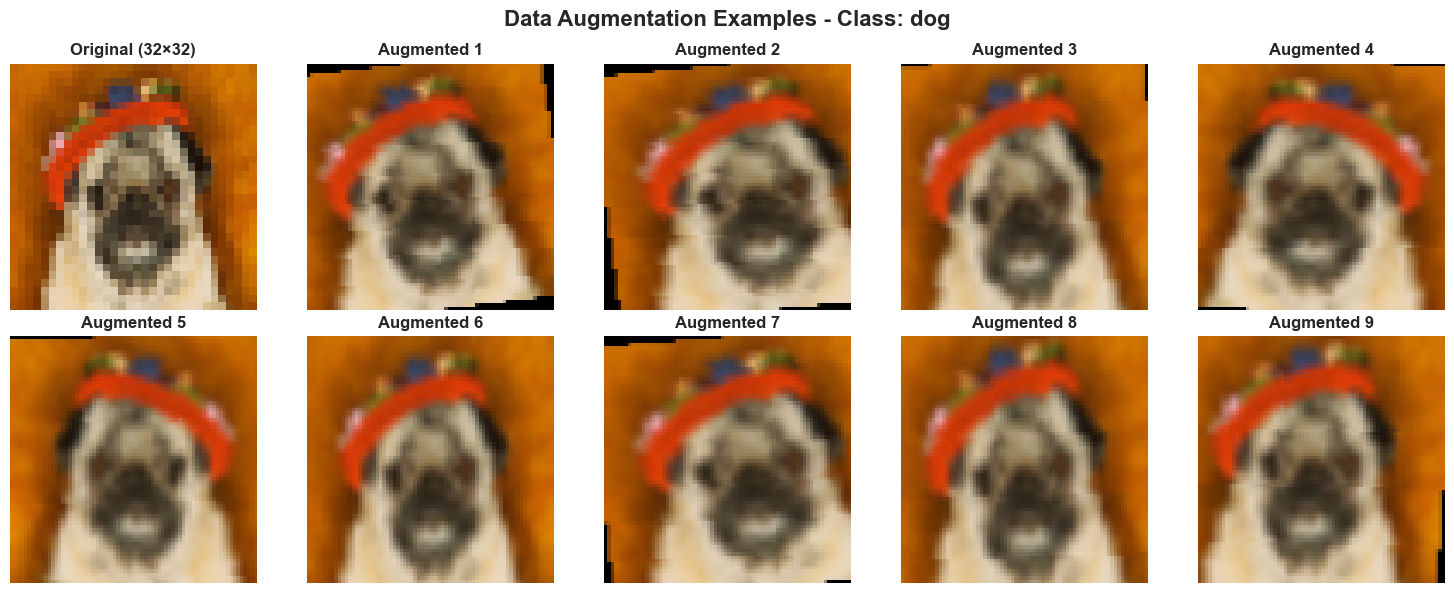

In [36]:
# Load same image with and without augmentation
import torchvision.transforms as transforms

# Load raw CIFAR-10
cifar_raw = torchvision.datasets.CIFAR10(
    root=config['data']['data_dir'],
    train=True,
    download=False,
    transform=transforms.ToTensor()
)

# Get one image
idx = np.random.randint(0, len(cifar_raw))
raw_img, label = cifar_raw[idx]

# Apply augmentations multiple times
from data import get_transforms
train_transform = get_transforms(config, train=True)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Original
axes[0, 0].imshow(raw_img.permute(1, 2, 0))
axes[0, 0].set_title('Original (32×32)', fontweight='bold')
axes[0, 0].axis('off')

# Augmented versions
from PIL import Image
raw_pil = Image.fromarray((raw_img.permute(1, 2, 0).numpy() * 255).astype(np.uint8))

for i in range(1, 5):
    aug_img = train_transform(raw_pil)
    
    # Denormalize
    aug_display = denormalize(
        aug_img,
        config['augmentation']['normalize_mean'],
        config['augmentation']['normalize_std']
    )
    aug_display = torch.clamp(aug_display, 0, 1)
    
    axes[0, i].imshow(aug_display.permute(1, 2, 0))
    axes[0, i].set_title(f'Augmented {i}', fontweight='bold')
    axes[0, i].axis('off')

# More augmentations
for i in range(5):
    aug_img = train_transform(raw_pil)
    
    aug_display = denormalize(
        aug_img,
        config['augmentation']['normalize_mean'],
        config['augmentation']['normalize_std']
    )
    aug_display = torch.clamp(aug_display, 0, 1)
    
    axes[1, i].imshow(aug_display.permute(1, 2, 0))
    axes[1, i].set_title(f'Augmented {i+5}', fontweight='bold')
    axes[1, i].axis('off')

plt.suptitle(f'Data Augmentation Examples - Class: {class_names[label]}',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Summary Statistics

In [37]:
print("= "*60)
print("CIFAR-10 Dataset Summary ")
print("= "*60)
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {', '.join(class_names)}")
print(f"\nOriginal image size: 32×32×3")
print(f"Resized image size: {config['data']['image_size']}×{config['data']['image_size']}×3")
print(f"Patch size: {patch_size}×{patch_size}")
print(f"Number of patches: {(config['data']['image_size']//patch_size)**2}")
print(f"\nBatch size: {config['data']['batch_size']}")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")
print("= "*60)

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
CIFAR-10 Dataset Summary 
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Number of classes: 10
Class names: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

Original image size: 32×32×3
Resized image size: 72×72×3
Patch size: 6×6
Number of patches: 144

Batch size: 256
Training samples: 45000
Validation samples: 5000
Test samples: 10000
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
